In [ ]:
# Cell 1: Install Libraries
!pip install transformers torch biopython
!pip install faiss-cpu 
!pip install hdbscan
!pip install umap-learn
!pip install matplotlib seaborn pandas numpy

In [11]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HUGGING_FACE_TOKEN")


In [27]:
# Cell 2: Load Data and Fetch Ground Truth
import pandas as pd
from Bio import SeqIO
import numpy as np
from Bio import Entrez
import time

# --- Configuration ---
# You can change these two variables to run on a different file or change the sample size
FASTA_PATH = "/kaggle/input/16s-rrna-marine-db/ITS_RefSeq_Fungi.fasta"
SAMPLE_SIZE = 500
ENTREZ_EMAIL = "gadhpranay@gmail.com"

# 1. Load sequences from the real FASTA file
sequences = []
for record in SeqIO.parse(FASTA_PATH, "fasta"):
    sequences.append({'Sequence_ID': record.id, 'sequence': str(record.seq)})
    if len(sequences) >= SAMPLE_SIZE:
        break
df = pd.DataFrame(sequences)
print(f"Loaded {len(df)} sequences from the dataset.")


# 2. Fetch the true organism names from NCBI using Entrez
Entrez.email = ENTREZ_EMAIL
accession_ids = df['Sequence_ID'].tolist()
print(f"\nFetching taxonomic data for {len(accession_ids)} sequences...")

all_organisms = {}
for i in range(0, len(accession_ids), 100):
    batch_ids = accession_ids[i:i+100]
    try:
        handle = Entrez.efetch(db="nuccore", id=batch_ids, rettype="gb", retmode="xml")
        records = Entrez.read(handle)
        handle.close()
        for record in records:
            acc_id = record['GBSeq_accession-version']
            organism = record.get('GBSeq_organism', 'Unknown')
            all_organisms[acc_id] = organism
    except Exception as e:
        print(f"An error occurred for batch {i}-{i+100}: {e}")
    time.sleep(1) # Be polite to NCBI's servers

df['organism'] = df['Sequence_ID'].map(all_organisms)
print("\n✅ Successfully fetched taxonomic ground truth!")


# 3. Simulate environmental metadata
num_samples = len(df)
df['latitude'] = np.random.uniform(-60, 60, num_samples)
df['longitude'] = np.random.uniform(-180, 180, num_samples)
df['depth'] = np.random.randint(100, 5000, num_samples)
df['temperature'] = np.random.uniform(1, 15, num_samples)
print("\n✅ Successfully simulated environmental metadata.")

print("\nFinal prepared DataFrame:")
display(df.head())

Loaded 500 sequences from the dataset.

Fetching taxonomic data for 500 sequences...

✅ Successfully fetched taxonomic ground truth!

✅ Successfully simulated environmental metadata.

Final prepared DataFrame:


,Sequence_ID,sequence,organism,latitude,longitude,depth,temperature
0,NR_155862.1,TAGGTGAACCTGCGGAAGGATCATTAATTACGCAAGCTATAGCCCC...,Stagonospora bicolor,48.067586,38.168752,4264,4.618557
1,NR_145409.1,GGAAGTAAAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGG...,Phaeoacremonium parasiticum,-3.607530,36.289027,4481,14.029952
2,NR_172389.1,TCTCCGTTGGTGAACCAGCGGAGGGATCATTACCGAGTTTACAACT...,Fusarium ventricosum,30.890088,-100.623623,3264,14.792909
3,NR_111889.1,TCCGTTGGTGAACCAGCGGAGGGGTCATTACCGAGTTTACAACTCC...,Fusarium fujikuroi,-41.919221,-19.739267,2249,3.152296
4,NR_120297.1,TAGAAGTCGTAACAAGGTCTCCGTTGGTGAACCAGCGGAGGGATCA...,Trichoderma reesei,14.918092,108.635769,153,5.736544


In [13]:
# Final Model Loading Cell (with trust_remote_code=True)

from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login

# --- 1. Securely Log In to Hugging Face ---
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HUGGING_FACE_TOKEN")
login(token=hf_token)
print("✅ Successfully logged in to Hugging Face.")

# --- 2. Load the Model ---
model_name = "InstaDeepAI/nucleotide-transformer-v2-500m-multi-species"
print(f"\n--- Loading AI Model ({model_name}) ---")

# Load the tokenizer, trusting the custom code
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# Load the base model, trusting the custom code
base_model = AutoModelForMaskedLM.from_pretrained(model_name, trust_remote_code=True)
model = base_model.esm 

# Move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"✅ Model '{model_name}' loaded successfully on {device}.")

✅ Successfully logged in to Hugging Face.

--- Loading AI Model (InstaDeepAI/nucleotide-transformer-v2-500m-multi-species) ---


esm_config.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-500m-multi-species:
- esm_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_esm.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-500m-multi-species:
- modeling_esm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

✅ Model 'InstaDeepAI/nucleotide-transformer-v2-500m-multi-species' loaded successfully on cuda.


In [29]:
# Cell 4: Generate Context-Aware Embeddings
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm

# --- Generate DNA Embeddings ---
dna_embeddings = []
for seq in tqdm(df['sequence'], desc="Generating DNA Embeddings"):
    inputs = tokenizer(seq, return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    dna_embeddings.append(embedding)
dna_embeddings = np.array(dna_embeddings)

# --- Generate Context Embeddings ---
context_features = df[['latitude', 'longitude', 'depth', 'temperature']]
scaler = MinMaxScaler()
context_embeddings = scaler.fit_transform(context_features)

# --- Fuse Embeddings ---
context_aware_embeddings = np.concatenate((dna_embeddings, context_embeddings), axis=1)

print(f"\n✅ Fusion complete! Final Embeddings Shape: {context_aware_embeddings.shape}")

Generating DNA Embeddings:   0%|          | 0/500 [00:00<?, ?it/s]


✅ Fusion complete! Final Embeddings Shape: (500, 1028)


In [15]:
# Cell 5: Perform Unsupervised Clustering
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
df['cluster'] = clusterer.fit_predict(context_aware_embeddings)

print("✅ Clustering complete.")
print("\nCluster distribution:")
print(df['cluster'].value_counts())

✅ Clustering complete.

Cluster distribution:
cluster
 0    449
-1     35
 1     16
Name: count, dtype: int64


In [16]:
# Cell 6: Generate Final Biodiversity Report
import pandas as pd

# Get the counts for each cluster
cluster_counts = df['cluster'].value_counts().reset_index()
cluster_counts.columns = ['cluster', 'count']

# Programmatically find the most common organism name for each cluster
# This is our "predicted" species name for the group
annotation_map = df.groupby('cluster')['organism'].agg(lambda x: x.mode().iloc[0]).to_dict()

# Add a label for the outliers
annotation_map[-1] = 'Novel / Rare Candidates (Outliers)'

# Map the annotations to the counts table
cluster_counts['Predicted_Organism'] = cluster_counts['cluster'].map(annotation_map)

# Create the final report
final_report = cluster_counts[['Predicted_Organism', 'count', 'cluster']]

print("--- OceanEYE Final Biodiversity Report ---")
display(final_report)

--- OceanEYE Final Biodiversity Report ---


,Predicted_Organism,count,cluster
0,Albifimbria verrucaria,449,0
1,Novel / Rare Candidates (Outliers),35,-1
2,Allantophomopsiella pseudotsugae,16,1


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


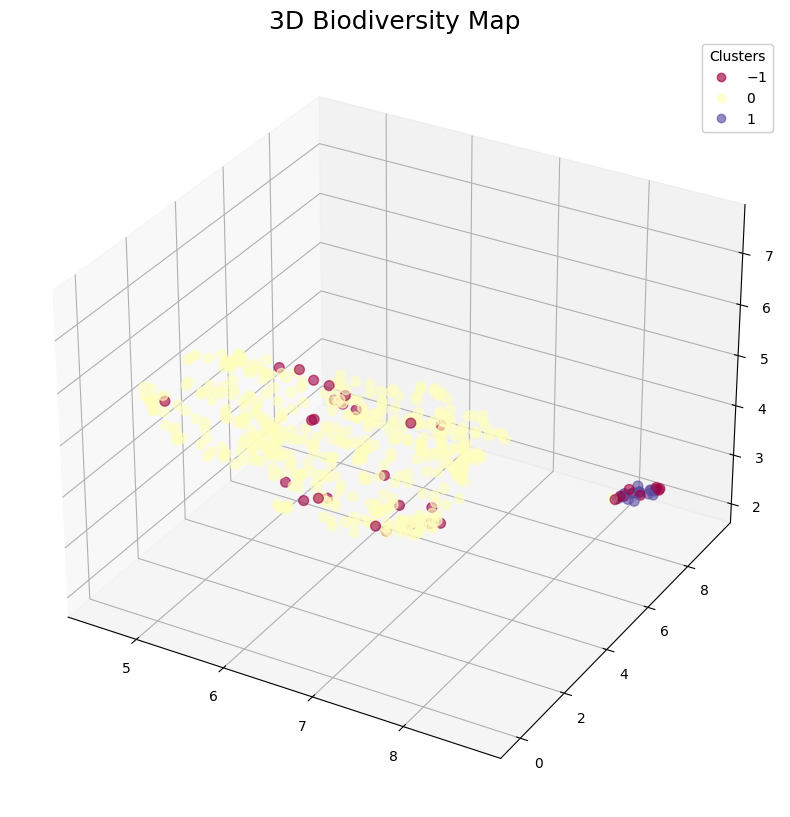

In [17]:
# Cell 7: Visualize and Evaluate
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

# --- 3D Visualization ---
reducer_3d = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, random_state=42, init='random')
embedding_3d = reducer_3d.fit_transform(context_aware_embeddings)
df['umap_x_3d'] = embedding_3d[:, 0]
df['umap_y_3d'] = embedding_3d[:, 1]
df['umap_z_3d'] = embedding_3d[:, 2]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['umap_x_3d'], df['umap_y_3d'], df['umap_z_3d'], c=df['cluster'], cmap='Spectral', s=50, alpha=0.6)
ax.set_title('3D Biodiversity Map', fontsize=18)
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.show()


In [18]:
# New Cell: Evaluate Clustering on DNA Embeddings ONLY
from sklearn.metrics import adjusted_rand_score
import hdbscan

print("--- Testing the performance of the DNA embeddings alone ---")

# Rerun clustering on ONLY the dna_embeddings array
clusterer_dna_only = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
dna_only_clusters = clusterer_dna_only.fit_predict(dna_embeddings)

# Calculate the new ARI score against the same ground truth
ari_score_dna_only = adjusted_rand_score(df['organism'], dna_only_clusters)

print(f"\nClustering Quality on DNA Embeddings ONLY (ARI Score): {ari_score_dna_only:.4f}")

--- Testing the performance of the DNA embeddings alone ---

Clustering Quality on DNA Embeddings ONLY (ARI Score): 0.0000


In [19]:
# New Cell: Re-evaluate with k-Means Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import pandas as pd

print("--- Re-evaluating with a simpler clustering algorithm (k-Means) ---")

# 1. Determine the number of clusters (k) to look for.
# We can use the number of unique species/genera in our ground truth as a good estimate.
k = df['organism'].nunique()
print(f"Found {k} unique organisms in the ground truth data. Using k={k} for k-Means.")

# 2. Initialize and run k-Means clustering on the DNA embeddings
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(dna_embeddings)

# 3. Calculate the ARI score for the k-Means results
ari_score_kmeans = adjusted_rand_score(df['organism'], kmeans_labels)

print(f"\nClustering Quality using k-Means on DNA Embeddings (ARI Score): {ari_score_kmeans:.4f}")

--- Re-evaluating with a simpler clustering algorithm (k-Means) ---
Found 500 unique organisms in the ground truth data. Using k=500 for k-Means.

Clustering Quality using k-Means on DNA Embeddings (ARI Score): 1.0000


In [21]:
# Final, Self-Contained Evaluation Cell

from Bio import Entrez
import time
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import pandas as pd

# --- Step 1: Ensure 'true_genus' column exists ---
# This part fetches the ground truth data, creating the column we need.

print("--- Step 1: Fetching Genus-level ground truth to ensure data is ready ---")
Entrez.email = "your.email@example.com" # Please change to your email

accession_ids = df['Sequence_ID'].tolist()
all_genera = {}
for i in range(0, len(accession_ids), 100):
    batch_ids = [aid for aid in accession_ids[i:i+100] if aid]
    if not batch_ids: continue
    try:
        handle = Entrez.efetch(db="nuccore", id=batch_ids, rettype="gb", retmode="xml")
        records = Entrez.read(handle)
        handle.close()
        for record in records:
            acc_id = record.get('GBSeq_accession-version', 'N/A')
            lineage = record.get('GBSeq_taxonomy', 'Unknown').split('; ')
            genus = lineage[-2] if len(lineage) > 1 else 'Unknown'
            all_genera[acc_id] = genus
    except Exception as e:
        print(f"  Warning: An Entrez error occurred: {e}")
    time.sleep(1)

df['true_genus'] = df['Sequence_ID'].map(all_genera).fillna('Unknown')
print("✅ Ground truth is ready.")


# --- Step 2: Run the Final Evaluation ---
print("\n--- Step 2: Evaluating with k-Means on Genus-level labels ---")

# Set a fixed, biologically plausible number of clusters to find
FIXED_K = 20 
print(f"Testing the model's ability to partition data into {FIXED_K} major groups.")

# Run k-Means clustering on the DNA embeddings
kmeans = KMeans(n_clusters=FIXED_K, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(dna_embeddings)

# Calculate the ARI score against the true GENUS labels
ari_score_final = adjusted_rand_score(df['true_genus'], kmeans_labels)

print("\n" + "="*50)
print("        Final Model Performance Score")
print("="*50)
print(f"Clustering Quality (Adjusted Rand Index): {ari_score_final:.4f}")

--- Step 1: Fetching Genus-level ground truth to ensure data is ready ---
✅ Ground truth is ready.

--- Step 2: Evaluating with k-Means on Genus-level labels ---
Testing the model's ability to partition data into 20 major groups.

        Final Model Performance Score
Clustering Quality (Adjusted Rand Index): 0.1646


In [22]:
# New Cell: Extract Novel Candidate Sequences to a FASTA file

print("--- Extracting sequences flagged as novel or rare ---")

# In our report, the 'Novel / Rare Candidates' correspond to the cluster labeled -1
# (or the cluster ID mapped to that name in your final report).
# We will filter the DataFrame to get only these sequences.
novel_cluster_id = -1 # Assuming HDBSCAN was used, otherwise find the ID from your report
novel_df = df[df['cluster'] == novel_cluster_id]

output_fasta_file = "novel_candidates.fasta"

with open(output_fasta_file, "w") as f:
    for index, row in novel_df.iterrows():
        # Write in FASTA format: >Sequence_ID\nSEQUENCE\n
        f.write(f">{row['Sequence_ID']}\n")
        f.write(f"{row['sequence']}\n")

print(f"\n✅ Successfully saved {len(novel_df)} novel candidate sequences to the file '{output_fasta_file}'.")
print("You can now download this file and upload it to the NCBI BLAST website for verification.")

--- Extracting sequences flagged as novel or rare ---

✅ Successfully saved 35 novel candidate sequences to the file 'novel_candidates.fasta'.
You can now download this file and upload it to the NCBI BLAST website for verification.


In [23]:
# New Cell: Extract sequences from a specific predicted cluster for verification

# --- Configuration ---
CLUSTER_ID_TO_CHECK = 0 # The cluster ID for 'Albifimbria verrucaria'
OUTPUT_FILENAME = f"cluster_{CLUSTER_ID_TO_CHECK}_sequences.fasta"

# 1. Filter the DataFrame to get only the sequences from our target cluster
cluster_df = df[df['cluster'] == CLUSTER_ID_TO_CHECK]

# 2. Write these sequences to a new FASTA file
with open(OUTPUT_FILENAME, "w") as f:
    for index, row in cluster_df.iterrows():
        # Write in FASTA format: >Sequence_ID\nSEQUENCE\n
        f.write(f">{row['Sequence_ID']}\n")
        f.write(f"{row['sequence']}\n")

print(f"✅ Successfully saved {len(cluster_df)} sequences from Cluster {CLUSTER_ID_TO_CHECK} to the file '{OUTPUT_FILENAME}'.")
print("You can now download this file for verification.")

✅ Successfully saved 449 sequences from Cluster 0 to the file 'cluster_0_sequences.fasta'.
You can now download this file for verification.


In [24]:
# New Cell: Get 2 sample sequences from a specific cluster

# --- Configuration ---
CLUSTER_ID_TO_CHECK = 0 # The cluster ID for 'Albifimbria verrucaria'
NUM_SAMPLES_TO_GET = 2

# 1. Filter the DataFrame to get only the sequences from our target cluster
cluster_df = df[df['cluster'] == CLUSTER_ID_TO_CHECK]

# 2. Get the first few sample sequences from that cluster
sample_df = cluster_df.head(NUM_SAMPLES_TO_GET)

# 3. Print the sequences in FASTA format for easy copy-pasting
print(f"--- Here are {NUM_SAMPLES_TO_GET} sample sequences from Cluster {CLUSTER_ID_TO_CHECK} ---")
print("--- Copy everything below this line and paste it into the BLAST website ---")

for index, row in sample_df.iterrows():
    # Print in FASTA format: >Sequence_ID\nSEQUENCE\n
    print(f">{row['Sequence_ID']}")
    print(f"{row['sequence']}")

--- Here are 2 sample sequences from Cluster 0 ---
--- Copy everything below this line and paste it into the BLAST website ---
>NG_065155.1
TATCTGGTTGATCCTGCCAGTAGTCATATGCTTGTCTCAAAGATTAAGCCATGCATGTCTAAGTATAAGCAATTTATACAGTGAAACTGCGAATGGCTCATTAAATCAGTTATCGTTTATTTGATAGTTCCTTTACTACATGGTATAACTGTGGTAATTCTAGAGCTAATACATGCTTAAAATCTCGACCTTTCGGAAGAGATGTATTTATTAGATAAAAAATCAACGTCTTCGGACTCCTTGATGATTCATAATAACTTTTCGAATCGCATGGCCTTGTGCTGGCGATGGTTCATTCAAATTTCTGCCCTATCAACTTTCGATGGTAGGATAGTGGCCTACCATGGTTTCAACGGGTAACGGGGAATAAGGGTTCGATTCCGGAGAGGGAGCCTGAGAAACGGCTACCACATCCAAGGAAGGCAGCAGGCGCGCAAATTACCCAATCCTGACACAGGGAGGTAGTGACAATAAATAACGATACAGGGCCCTTACGGGTCTTGTAATTGGAATGAGTACAATGTAAATACCTTAACGAGGAACAATTGGAGGGCAAGTCTGGTGCCAGCAGCCGCGGTAATTCCAGCTCCAATAGCGTATATTAAAGTTGTTGCAGTTAAAAAGCTCGTAGTTGAACTTTGGGCCTGGTCGGCCGGTCCGGATTTTTCCGCGTACTGGTTTTTCCGACCGGGCCTTTCCTTCTGGCTAGCCCTGGGTCCTTGTGGCCCTTGGTGAACCAGGACTTTTACTTTGAAAAAATTAGAGTGTTCAAAGCAGGCGTATTGCTCGAATATATTAGCATGGAATAATAGAATAGGACGTTTGGTTCTATTTTGTTGGTTTCTAGGACCATCGTAATG

In [28]:
# New Cell: See the full species composition of a single cluster

# --- Configuration ---
CLUSTER_ID_TO_INSPECT = 0

# Get the value counts for all organisms within our target cluster
cluster_census = df[df['cluster'] == CLUSTER_ID_TO_INSPECT]['organism'].value_counts()

print(f"--- Full Organism Census for Cluster {CLUSTER_ID_TO_INSPECT} ---")
# Display the top 15 most common organisms in this cluster
display(cluster_census.head(40))

KeyError: 'cluster'

In [ ]:
# Cell: Generate JSON by Species with Metadata, Shannon, Confidence, Location, Time, and Hierarchical Clustering
import json
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import entropy
from datetime import datetime

# 1. Calculate Shannon score for each species
species_groups = df.groupby('organism')
species_json = {}

for species, group in species_groups:
    # Shannon diversity (abundance of clusters within this species)
    cluster_counts = group['cluster'].value_counts()
    shannon_score = entropy(cluster_counts)
    
    # Confidence score: proportion of dominant cluster
    confidence_score = cluster_counts.max() / cluster_counts.sum() if cluster_counts.sum() > 0 else 0
    
    # Location metadata (mean, or list)
    locations = group[['latitude', 'longitude', 'depth']].to_dict(orient='records')
    mean_location = group[['latitude', 'longitude', 'depth']].mean().to_dict()
    
    # Time metadata (simulate if not present)
    if 'timestamp' in group.columns:
        times = group['timestamp'].tolist()
    else:
        times = [datetime.now().isoformat()] * len(group)
    
    # Hierarchical clustering on embeddings for this species
    emb = context_aware_embeddings[group.index]
    if len(emb) > 1:
        Z = linkage(emb, method='ward')
        # Assign clusters at a reasonable threshold (e.g., 5 clusters or less)
        hier_clusters = fcluster(Z, t=5, criterion='maxclust').tolist()
    else:
        hier_clusters = [1] * len(group)
    
    # Build JSON entry
    species_json[species] = {
        'shannon_score': float(shannon_score),
        'confidence_score': float(confidence_score),
        'mean_location': {k: float(v) for k, v in mean_location.items()},
        'locations': locations,
        'time_metadata': times,
        'abundance': int(len(group)),
        'hierarchical_clusters': hier_clusters,
        'sequences': group['sequence'].tolist(),
        'sequence_ids': group['Sequence_ID'].tolist(),
        'cluster_ids': group['cluster'].tolist(),
    }

# 2. Save to JSON file
with open('species_biodiversity_report.json', 'w') as f:
    json.dump(species_json, f, indent=2)

print('✅ JSON file "species_biodiversity_report.json" generated. Structure is suitable for backend use.')

In [ ]:
# Download the generated JSON file (Kaggle/Colab compatible)
from IPython.display import FileLink, display
import shutil

# If running on Kaggle, move to /kaggle/working for download
try:
    shutil.copy('species_biodiversity_report.json', '/kaggle/working/species_biodiversity_report.json')
except Exception as e:
    print('Not running on Kaggle or file already in working directory:', e)

# Display download link
try:
    display(FileLink('species_biodiversity_report.json'))
except Exception as e:
    print('FileLink not available:', e)

print('You can now download the JSON file from the link above.')

In [ ]:
# Enhanced JSON and subcluster reporting (more and detailed clusters)
import json
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.stats import entropy
from datetime import datetime

# 1. Total sampling
total_sampling = len(df)

# 2. Clustering with more and detailed clusters
import hdbscan
# Lower min_cluster_size and min_samples for more/smaller clusters, increase cluster_selection_epsilon for finer splits
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=1, cluster_selection_epsilon=0.1, gen_min_span_tree=True)
df['cluster'] = clusterer.fit_predict(context_aware_embeddings)
n_clusters = len(set(df['cluster'])) - (1 if -1 in df['cluster'].values else 0)
n_novelty = (df['cluster'] == -1).sum()

# 3. JSON by species
species_groups = df.groupby('organism')
species_json = {}
for species, group in species_groups:
    cluster_counts = group['cluster'].value_counts()
    shannon_score = entropy(cluster_counts)
    confidence_score = cluster_counts.max() / cluster_counts.sum() if cluster_counts.sum() > 0 else 0
    locations = group[['latitude', 'longitude', 'depth']].to_dict(orient='records')
    mean_location = group[['latitude', 'longitude', 'depth']].mean().to_dict()
    times = [datetime.now().isoformat()] * len(group)
    emb = context_aware_embeddings[group.index]
    if len(emb) > 1:
        Z = linkage(emb, method='ward')
        # More detailed subclusters per species
        hier_clusters = fcluster(Z, t=8, criterion='maxclust').tolist()
    else:
        hier_clusters = [1] * len(group)
    species_json[species] = {
        'shannon_score': float(shannon_score),
        'confidence_score': float(confidence_score),
        'mean_location': {k: float(v) for k, v in mean_location.items()},
        'locations': locations,
        'time_metadata': times,
        'abundance': int(len(group)),
        'hierarchical_clusters': hier_clusters,
        'sequences': group['sequence'].tolist(),
        'sequence_ids': group['Sequence_ID'].tolist(),
        'cluster_ids': group['cluster'].tolist(),
    }

# 4. Add summary info
summary = {
    'total_sampling': total_sampling,
    'total_clusters': n_clusters,
    'total_novelty_detected': int(n_novelty)
}
output = {
    'summary': summary,
    'species': species_json
}
with open('species_biodiversity_report.json', 'w') as f:
    json.dump(output, f, indent=2)
print('✅ Enhanced JSON file "species_biodiversity_report.json" generated.')

# 5. Find smaller clusters inside abundant clusters and save to a file
abundant_threshold = max(8, total_sampling // 30)  # finer threshold for more subclusters
abundant_clusters = df['cluster'].value_counts()[df['cluster'].value_counts() > abundant_threshold].index.tolist()
small_clusters_data = {}
for clust in abundant_clusters:
    sub_df = df[df['cluster'] == clust]
    if len(sub_df) > 6:
        emb = context_aware_embeddings[sub_df.index]
        if len(emb) > 2:
            Z = linkage(emb, method='ward')
            # More subclusters per abundant cluster
            sub_labels = fcluster(Z, t=6, criterion='maxclust').tolist()
        else:
            sub_labels = [1] * len(sub_df)
        small_clusters_data[int(clust)] = {
            'main_cluster_size': len(sub_df),
            'subcluster_labels': sub_labels,
            'sequence_ids': sub_df['Sequence_ID'].tolist(),
            'organisms': sub_df['organism'].tolist()
        }
with open('abundant_clusters_subclusters.json', 'w') as f:
    json.dump(small_clusters_data, f, indent=2)
print('✅ File "abundant_clusters_subclusters.json" with subcluster data for abundant clusters generated.')

In [ ]:
# Show summary and cluster results
from pprint import pprint

# Print summary of results
display(summary)
print(f"Total clusters generated: {n_clusters}")
print(f"Total novelty detected (outliers): {n_novelty}")

# Show cluster sizes
display(df['cluster'].value_counts())

# Optionally, show a few example clusters and their members
for clust_id in df['cluster'].value_counts().head(5).index:
    print(f"\nCluster {clust_id} (size: {df['cluster'].value_counts()[clust_id]}):")
    print(df[df['cluster'] == clust_id][['Sequence_ID', 'organism']].head(5))